In [1]:
# read data: merge year, month, day , hour and save as pollution.csv
from datetime import datetime
import pandas as pd

In [2]:
def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')
dataset = pd.read_csv('./raw.csv',parse_dates =[['year','month','day','hour']], index_col=0,date_parser=parse )
dataset.drop('No',axis=1,inplace=True)

# change col names
dataset.columns = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
dataset.index.name='date'

# imputation
dataset['pollution'].fillna(0,inplace=True)
# drop the fist day (24h)'s data  # the fisrt day's pm2.5=nan
dataset =dataset[24:]
print(dataset.head(5))

#save csv
dataset.to_csv('pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [3]:
# use new dataset pollution
dataset=pd.read_csv('pollution.csv',index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [4]:
values =dataset.values
print(values)
print(values.shape)  #8 features, includes pm2.5

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
(43800, 8)


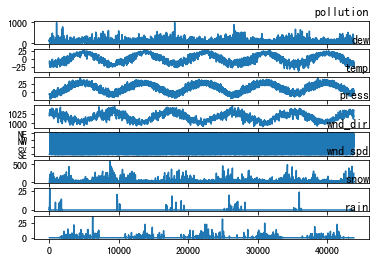

In [5]:
import matplotlib.pyplot as plt
groups = [0,1,2,3,4,5,6,7]
i=1
for group in range(8):
    plt.subplot(8,1,i)  # subplot 
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],loc='right')
    i=i+1
plt.show()  # then realize wind dir is categrical data

In [6]:
# label encoder  wnd_dir (the 5th: 4)
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
encoder=LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
print(values[:,4])

[2 2 2 ... 1 1 1]


In [7]:
# rescale variables : 0-1 normalization
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
print(scaled)



[[0.12977867 0.35294118 0.24590164 ... 0.00229001 0.         0.        ]
 [0.14889336 0.36764706 0.24590164 ... 0.00381099 0.         0.        ]
 [0.15995976 0.42647059 0.2295082  ... 0.00533197 0.         0.        ]
 ...
 [0.01006036 0.26470588 0.26229508 ... 0.41399641 0.         0.        ]
 [0.00804829 0.26470588 0.24590164 ... 0.42086644 0.         0.        ]
 [0.01207243 0.27941176 0.26229508 ... 0.4262155  0.         0.        ]]


In [11]:
# convert time series data for supervised learning
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from itertools import chain

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropna:
        agg.dropna(inplace=True)
    return agg
reframed = series_to_supervised(scaled,1,1)
reframed.to_csv('reframed-1,csv')

In [12]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763636,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [13]:
# get rid of data that we do not need to forecast var(2)-var(8)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]],axis=1,inplace=True)
reframed.to_csv('reframed-2.csv')


In [25]:
# split train 80% test 20%
# can not use train_test_split cuz it's panel
# split by time 
values = reframed.values
n_train_hours = int(len(values)*0.8)

train= values[: n_train_hours,:]
test=values[n_train_hours:,:]

In [26]:
train

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.        , 0.        ,
        0.15995976],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.        , 0.        ,
        0.18209256],
       ...,
       [0.01810865, 0.27941176, 0.42622951, ..., 0.        , 0.        ,
        0.02313883],
       [0.02313883, 0.27941176, 0.42622951, ..., 0.        , 0.        ,
        0.02012072],
       [0.02012072, 0.27941176, 0.40983607, ..., 0.        , 0.        ,
        0.02313883]])

In [29]:
# 
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)
train_X = train[:,:-1] 
# 0 to the last colunm  :-1 from 0 to the second last (aka delete the last one)
# -1: the last column
 
 

(35039, 8)


In [30]:
# formating to 3d  #[sample size, time step, #feature ]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X)

In [31]:
train_X.shape

(35039, 1, 8)

In [34]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


# set net model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8, train_X.shape = (35039, 1, 8)
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
results =model.fit(train_X, train_y, epochs=10, batch_size=32,validation_data=(test_X,test_y),verbose=2,shuffle=False)


Epoch 1/10
1095/1095 - 48s - loss: 0.0025 - val_loss: 0.0026
Epoch 2/10
1095/1095 - 64s - loss: 8.0658e-04 - val_loss: 0.0013
Epoch 3/10
1095/1095 - 49s - loss: 8.0923e-04 - val_loss: 0.0013
Epoch 4/10
1095/1095 - 46s - loss: 8.1426e-04 - val_loss: 0.0013
Epoch 5/10
1095/1095 - 51s - loss: 8.1306e-04 - val_loss: 0.0012
Epoch 6/10
1095/1095 - 54s - loss: 8.1062e-04 - val_loss: 0.0012
Epoch 7/10
1095/1095 - 46s - loss: 8.0807e-04 - val_loss: 0.0012
Epoch 8/10
1095/1095 - 48s - loss: 8.0568e-04 - val_loss: 0.0012
Epoch 9/10
1095/1095 - 47s - loss: 8.0349e-04 - val_loss: 0.0012
Epoch 10/10
1095/1095 - 50s - loss: 8.0153e-04 - val_loss: 0.0012


In [35]:
# forecast
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)


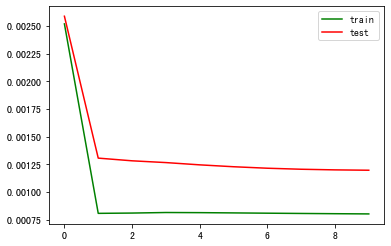

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# plot
line1 = results.history['loss']
line2 = results.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())

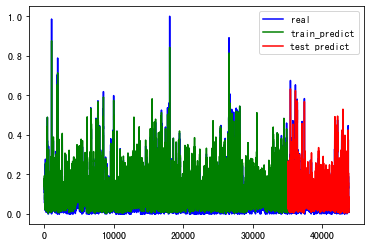

In [41]:
def plot_img(source_data_set,train_predict,test_predict):
    # original data
    plt.plot(source_data_set[:,-1],label='real',c='b')
    # train's prediction
    plt.plot([x for x in train_predict],label='train_predict',c='g')
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
     # draw after train predict
    plt.legend()
    plt.show()
# compare train results to real and show in a plot   
plot_img(values, train_predict, test_predict)